# Results Reproducibility (Experiments under Gaussian noise and blur)

You can reproduce our paper results following this notebook.

Please, make sure to replace `image_test.jpg`  with you own image.

also to run this code, libraries should be installed from `pip install -r requirements.txt`

### 1- Importing necessary libraries

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from similarity_metrics.ssim_rmse_psnr_metrics import rmse, psnr, ssim
from similarity_metrics.fsim_quality import FSIMsimilarity
from similarity_metrics.issm_quality import ISSMsimilarity
from CopulaSimilarity.CSM import CopulaBasedSimilarity as CSIMSimilarity
import pickle


### 1- Example of Gaussian Noising and Blurring on an image

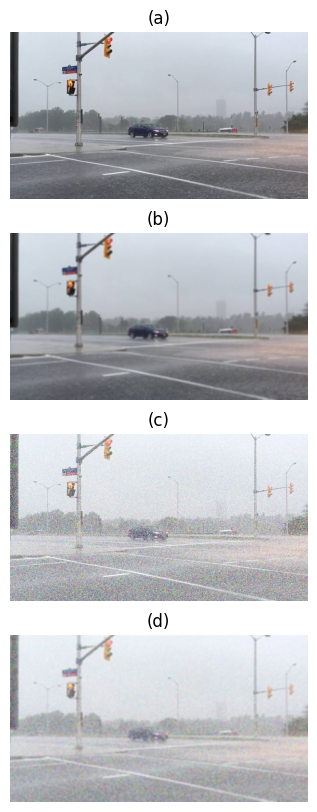

In [8]:
image_path = 'examples/image_test.jpg'
image = cv2.imread(image_path)

def add_gaussian_noise(image, mean=1, sigma=20):
    """Add Gaussian noise to an image."""
    gauss = np.random.normal(mean, sigma, image.shape).astype('uint8')
    noisy_image = cv2.add(image, gauss)
    return noisy_image

def apply_gaussian_blur(image, kernel_size=(9, 9), sigma=20):
    """Apply Gaussian Blur to an image."""
    blurred_image = cv2.GaussianBlur(image, kernel_size, sigma)
    return blurred_image

noised_image = add_gaussian_noise(image, mean=2, sigma=10)

blurred_image = apply_gaussian_blur(image)

blurred_noised_image = apply_gaussian_blur(noised_image)

plt.figure(figsize=(15, 10))

plt.subplot(4, 1, 1)
plt.title('(a)')
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB)) 
plt.axis('off')

plt.subplot(4, 1, 2)
plt.title('(b)')
plt.imshow(cv2.cvtColor(blurred_image, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(4, 1, 3)
plt.title('(c)')
plt.imshow(cv2.cvtColor(noised_image, cv2.COLOR_BGR2RGB)) 
plt.axis('off')

plt.subplot(4, 1, 4)
plt.title('(d)')
plt.imshow(cv2.cvtColor(blurred_noised_image, cv2.COLOR_BGR2RGB)) 
plt.axis('off')

plt.savefig('visualization_noise_blur.pdf', format='pdf')
plt.show()

### 2- Run static test to compare original and blurred image

⚠️ :warning: FSIM is the metric that takes the longest to run, you can comment it if you'd like fast results

SSIM: 0.6015
RMSE: 0.0111
PSNR: 39.0657 dB
ISSM: 0.0995
FSIM: 0.4185
CSM Mean: 0.1311
CSM Max: 0.7669
CSM Min: 0.0000


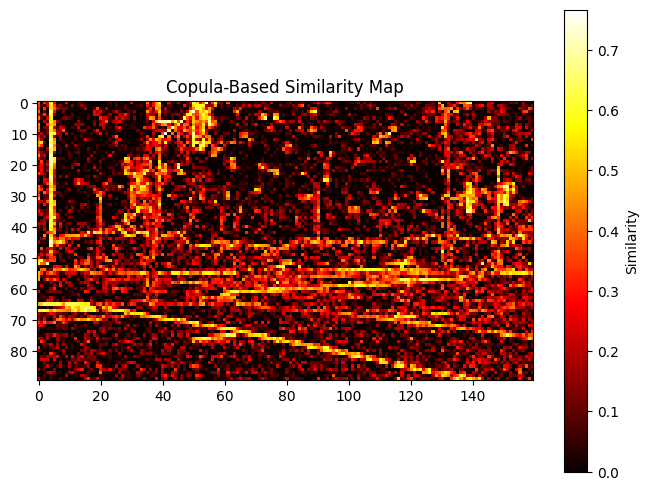

In [5]:
fsim_similarity = FSIMsimilarity()
issm_similarity = ISSMsimilarity()
copula_similarity = CSIMSimilarity()

ssim_value = ssim(image, blurred_image) 
rmse_value = rmse(image, blurred_image)  
psnr_value = psnr(image, blurred_image)  
issm_value = issm_similarity.issm(image, blurred_image)
fsim_value = fsim_similarity.fsim(image, blurred_image)
csim_value = copula_similarity.compute_local_similarity(image, blurred_image)

csim_mean = np.mean(csim_value)

print(f"SSIM: {ssim_value:.4f}")
print(f"RMSE: {rmse_value:.4f}")
print(f"PSNR: {psnr_value:.4f} dB")
print(f"ISSM: {issm_value:.4f}")
print(f"FSIM: {fsim_value:.4f}")
print(f"CSIM Mean: {csim_mean:.4f}")

csim_max = np.max(csim_value)
csim_min = np.min(csim_value)
print(f"CSIM Max: {csim_max:.4f}")
print(f"CSIM Min: {csim_min:.4f}")

plt.figure(figsize=(8, 6))
plt.title('Copula-Based Similarity Map')
plt.imshow(csim_value, cmap='hot', interpolation='nearest')
plt.colorbar(label='Similarity')
plt.show()


### 3- Experimenting metrics on images under varying gaussian noise and blur

In [7]:
def add_gaussian_noise(image, mean=2, sigma=0):
    """Add Gaussian noise to an image."""
    gauss = np.random.normal(mean, sigma, image.shape).astype('uint8')
    return cv2.add(image, gauss)

def apply_gaussian_blur(image, sigma=10):
    """Apply Gaussian Blur to an RGB image."""
    kernel_size = (5, 5)
    return cv2.GaussianBlur(image, kernel_size, sigma)

def compute_metrics(original_image, distorted_image, csim_calculator, issm_calculator):
    """Compute FSIM, SSIM, CSIM, and ISSM metrics."""
    try:
        fsim_score = FSIMsimilarity().fsim(org_img=original_image, pred_img=distorted_image)
        ssim_score = ssim(original_image, distorted_image)
        issm_score = issm_calculator.issm(original_image, distorted_image)
        csim_map = csim_calculator.compute_local_similarity(original_image, distorted_image)

        csim_score = np.mean(csim_map)

        print(f"FSIM: {fsim_score}, SSIM: {ssim_score}, ISSM: {issm_score}, CSIM: {csim_score}, ")
        return fsim_score, ssim_score, csim_score, issm_score

    except Exception as e:
        print(f"Error computing metrics: {e}")
        return None, None, None, None

def compute_all_similarities(image, noise_params, blur_sigmas):
    """Compute similarity metrics for RGB images with varying noise and blur."""
    blur_levels = blur_sigmas
    noise_means = noise_params['means']
    noise_sigmas = noise_params['sigmas']

    fsim_blur = []
    fsim_noise = []
    ssim_blur = []
    ssim_noise = []
    csim_blur = []
    csim_noise = []
    issm_blur = []
    issm_noise = []

    fsim_combined = np.zeros((len(noise_means), len(blur_levels)), dtype=float)
    ssim_combined = np.zeros((len(noise_means), len(blur_levels)), dtype=float)
    csim_combined = np.zeros((len(noise_means), len(blur_levels)), dtype=float)
    issm_combined = np.zeros((len(noise_means), len(blur_levels)), dtype=float)

    csim_calculator = CSIMSimilarity()
    issm_calculator = ISSMsimilarity()

    blurred_images = [apply_gaussian_blur(image, sigma) for sigma in blur_levels]
    
    for mean in noise_means:
        noisy_images = [add_gaussian_noise(image, mean=mean, sigma=sigma) for sigma in noise_sigmas]
        
        for blur_level, blurred_image in zip(blur_levels, blurred_images):
            fsim_score, ssim_score, csim_score, issm_score = compute_metrics(image, blurred_image, csim_calculator, issm_calculator)
            fsim_blur.append(fsim_score)
            ssim_blur.append(ssim_score)
            csim_blur.append(csim_score)
            issm_blur.append(issm_score)

        for noise_level, noisy_image in zip(noise_sigmas, noisy_images):
            fsim_score, ssim_score, csim_score, issm_score = compute_metrics(image, noisy_image, csim_calculator, issm_calculator)
            fsim_noise.append(fsim_score)
            ssim_noise.append(ssim_score)
            csim_noise.append(csim_score)
            issm_noise.append(issm_score)
        
        for i, noisy_image in enumerate(noisy_images):
            for j, blurred_image in enumerate(blurred_images):
                noisy_blurred_image = cv2.GaussianBlur(noisy_image, (5, 5), blur_levels[j])
                fsim_score, ssim_score, csim_score, issm_score = compute_metrics(image, noisy_blurred_image, csim_calculator, issm_calculator)
                
                fsim_combined[0, j] = fsim_score
                ssim_combined[0, j] = ssim_score
                csim_combined[0, j] = csim_score
                issm_combined[0, j] = issm_score

    return blur_levels, noise_sigmas, fsim_blur, fsim_noise, fsim_combined, ssim_blur, ssim_noise, ssim_combined, csim_blur, csim_noise, csim_combined, issm_blur, issm_noise, issm_combined


In [8]:
def plot_results(blur_levels, noise_means, csim_blur, csim_noise, csim_combined, ssim_blur, ssim_noise, ssim_combined, fsim_blur, fsim_noise, fsim_combined, issm_blur, issm_noise, issm_combined):
    """Plot the results of the similarity computations including FSIM, SSIM, CSIM, and ISSM."""
    figures = []
    
    fig1 = plt.figure(figsize=(14, 7))
    plt.plot(blur_levels, csim_blur, label='Copula-Based Similarity')
    plt.plot(blur_levels, ssim_blur, label='SSIM')
    plt.plot(blur_levels, fsim_blur, label='FSIM')
    plt.plot(blur_levels, issm_blur, label='ISSM')
    plt.xlabel('Blur Sigma')
    plt.ylabel('Similarity Score')
    plt.legend()
    plt.grid()
    plt.close(fig1)
    figures.append(fig1)

    fig2 = plt.figure(figsize=(14, 7))
    plt.plot(noise_means, csim_noise, label='Copula-Based Similarity')
    plt.plot(noise_means, ssim_noise, label='SSIM')
    plt.plot(noise_means, fsim_noise, label='FSIM')
    plt.plot(noise_means, issm_noise, label='ISSM')
    plt.xlabel('Noise Sigma')
    plt.ylabel('Similarity Score')
    plt.legend()
    plt.grid()
    plt.close(fig2)
    figures.append(fig2)

    fig3 = plt.figure(figsize=(14, 10))
    ax1 = fig3.add_subplot(111, projection='3d')
    blur_values, noise_values = np.meshgrid(blur_levels, noise_means, indexing='ij')
    ax1.plot_surface(blur_values, noise_values, csim_combined.T, cmap='viridis')
    ax1.set_xlabel('Blur Sigma', labelpad=10)
    ax1.set_ylabel('Noise Mean', labelpad=10)
    ax1.set_zlabel('CSIM', labelpad=10)
    ax1.set_zlim(0.0, 1.0)
    ax1.set_title('CSIM vs. Blur and Noise', pad=20)
    plt.close(fig3)
    figures.append(fig3)

    fig4 = plt.figure(figsize=(14, 10))
    ax2 = fig4.add_subplot(111, projection='3d')
    ax2.plot_surface(blur_values, noise_values, ssim_combined.T, cmap='viridis')
    ax2.set_xlabel('Blur Sigma', labelpad=10)
    ax2.set_ylabel('Noise Mean', labelpad=10)
    ax2.set_zlabel('SSIM', labelpad=10)
    ax2.set_zlim(0.0, 1.0)
    ax2.set_title('SSIM vs. Blur and Noise', pad=20)
    plt.close(fig4)
    figures.append(fig4)

    fig5 = plt.figure(figsize=(14, 10))
    ax3 = fig5.add_subplot(111, projection='3d')
    ax3.plot_surface(blur_values, noise_values, fsim_combined.T, cmap='viridis')
    ax3.set_xlabel('Blur Sigma', labelpad=10)
    ax3.set_ylabel('Noise Mean', labelpad=10)
    ax3.set_zlabel('FSIM', labelpad=10)
    ax3.set_zlim(0.0, 1.0)
    ax3.set_title('FSIM vs. Blur and Noise', pad=20)
    plt.close(fig5)
    figures.append(fig5)

    fig6 = plt.figure(figsize=(14, 10))
    ax4 = fig6.add_subplot(111, projection='3d')
    ax4.plot_surface(blur_values, noise_values, issm_combined.T, cmap='viridis')
    ax4.set_xlabel('Blur Sigma', labelpad=10)
    ax4.set_ylabel('Noise Mean', labelpad=10)
    ax4.set_zlabel('ISSM', labelpad=10)
    ax4.set_zlim(0.0, 1.0)
    ax4.set_title('ISSM vs. Blur and Noise', pad=20)
    plt.close(fig6)
    figures.append(fig6)
    
    return figures


### 4- Run the loop:

This step take too long to run. You can skip the following cells up to [### 5- Visualization](#5--Visualization)

In case you'd like to parallalize this process on multiple CPU cores you can use the following library `pip install joblib`.

Therefore you to comment or uncomment the lines `process_all_means(parallel_process=True)` or `process_all_means(parallel_process=False)` depending on the need.

In [6]:
from joblib import Parallel, delayed

def process_all_means(parallel_process=True):
    noise_params = {'means': np.linspace(0, 10, 11), 'sigmas': np.linspace(0, 20, 20)}
    blur_sigmas = np.linspace(0, 20, 20)

    def process_mean(mean):
        print(f"Processing noise mean: {mean}")
        current_noise_params = {'means': [mean], 'sigmas': noise_params['sigmas']}
        
        results = compute_all_similarities(image, current_noise_params, blur_sigmas)
        
        blur_levels, noise_means, fsim_blur, fsim_noise, fsim_combined, ssim_blur, ssim_noise, ssim_combined, csim_blur, csim_noise, csim_combined, issm_blur, issm_noise, issm_combined = results
        
        plot_results(blur_levels, noise_means, csim_blur, csim_noise, csim_combined, ssim_blur, ssim_noise, ssim_combined, fsim_blur, fsim_noise, fsim_combined, issm_blur, issm_noise, issm_combined)

        with open(f'pkldata/results_data_mean_{mean}.pkl', 'wb') as f:
            pickle.dump(results, f)

        print(f"Completed processing for noise mean: {mean}")

    if parallel_process:
        Parallel(n_jobs=-1)(delayed(process_mean)(mean) for mean in noise_params['means'])
    else:
        for mean in noise_params['means']:
            process_mean(mean)

In [ ]:
process_all_means(parallel_process=True)  # Use parallel processing
#process_all_means(parallel_process=False)  # Process means sequentially

### 5- Visualization

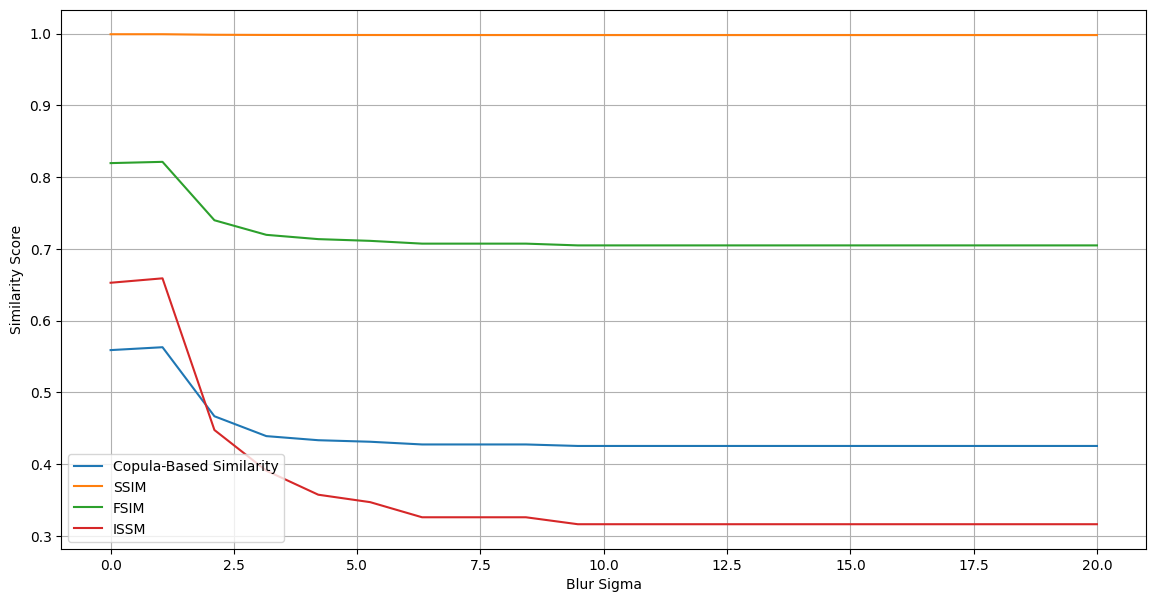

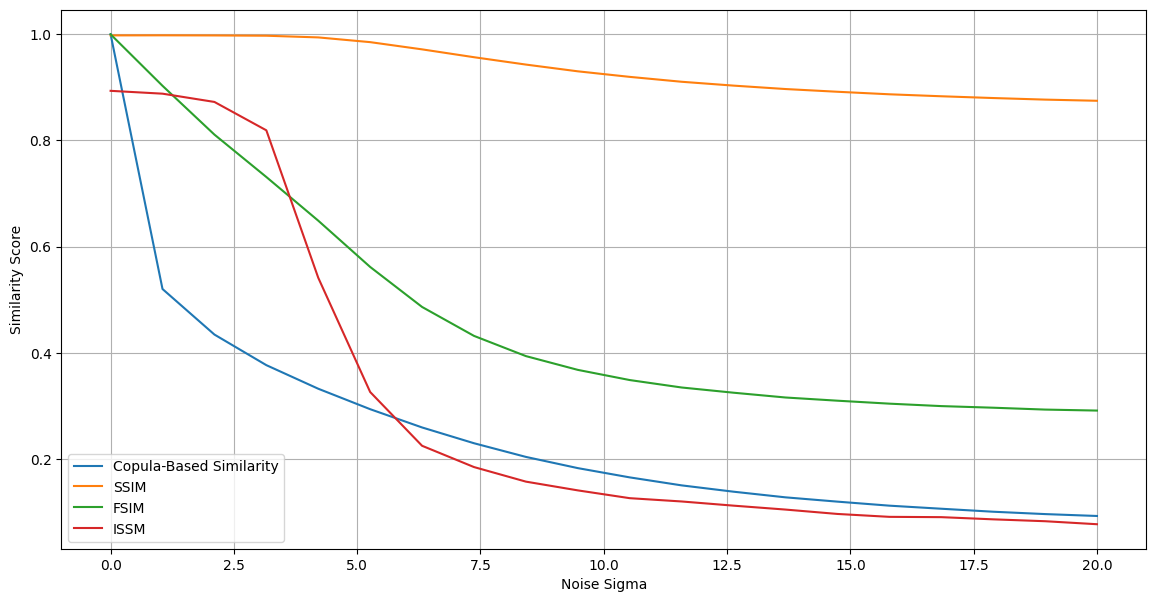

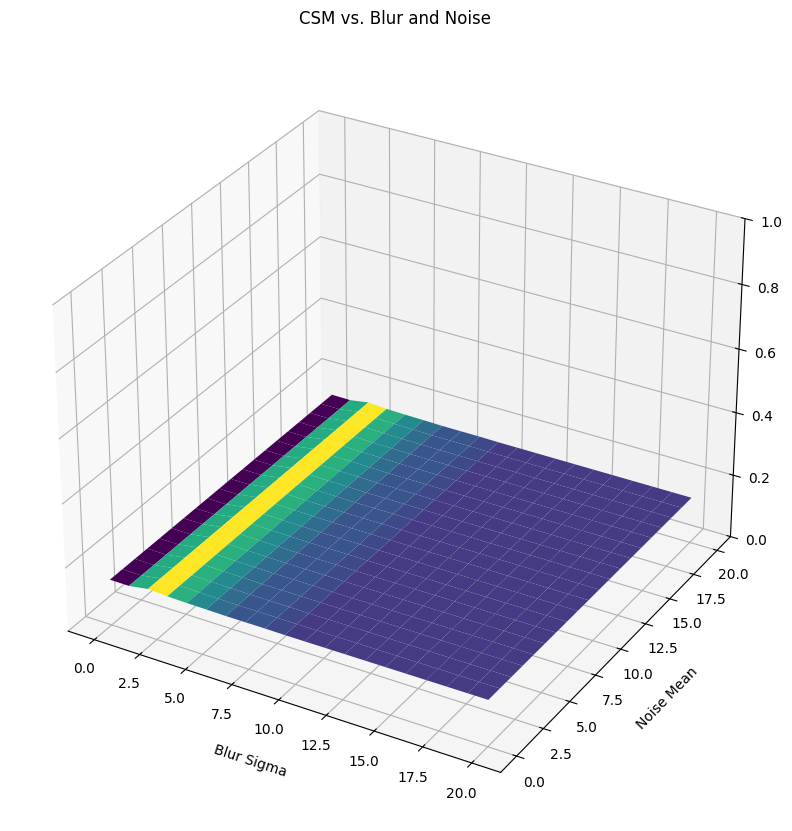

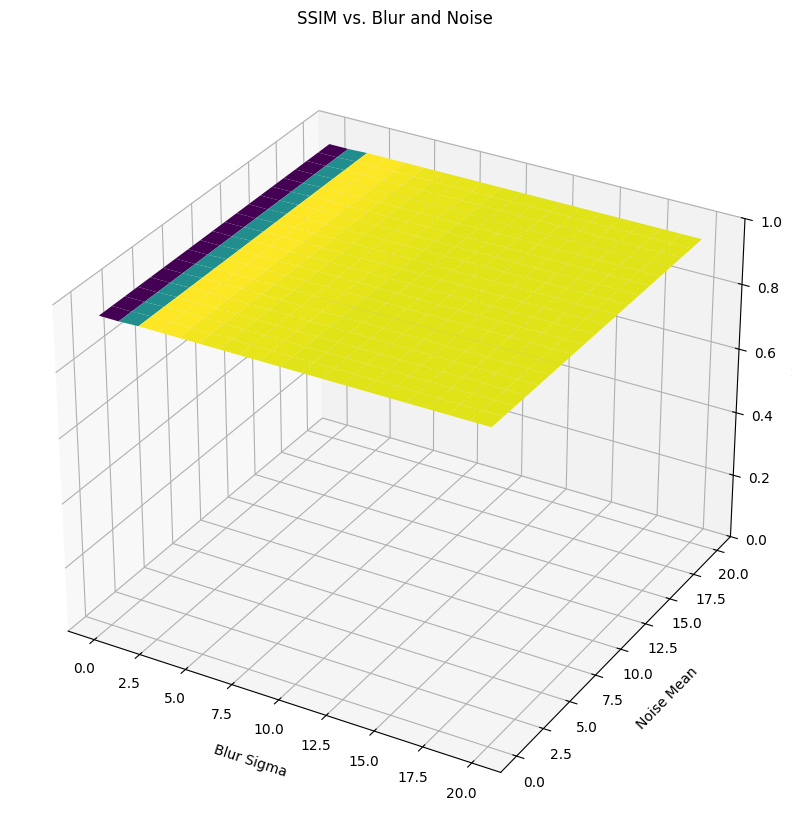

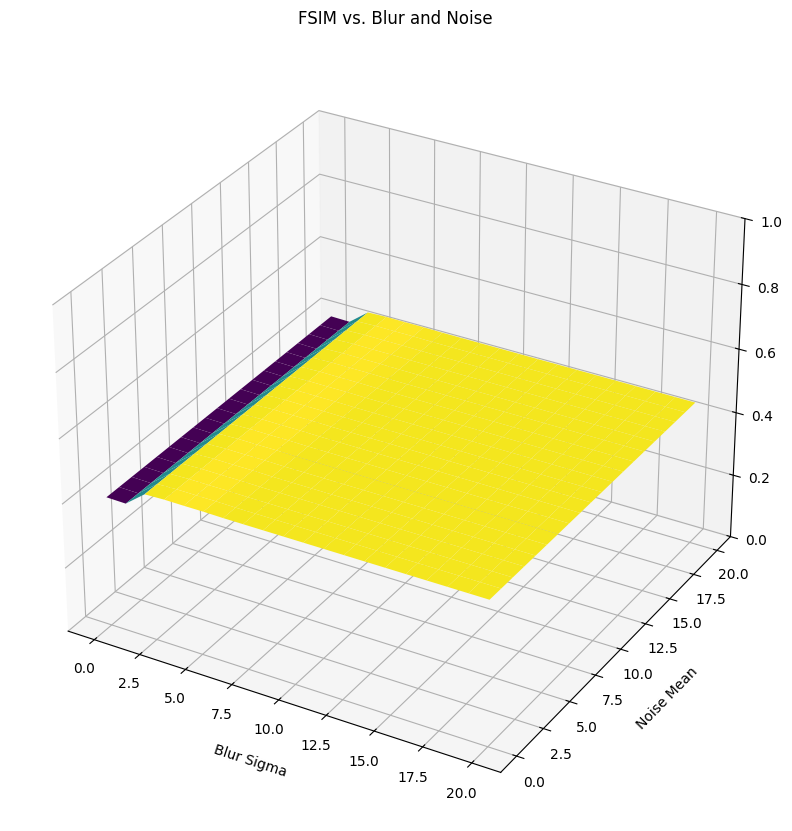

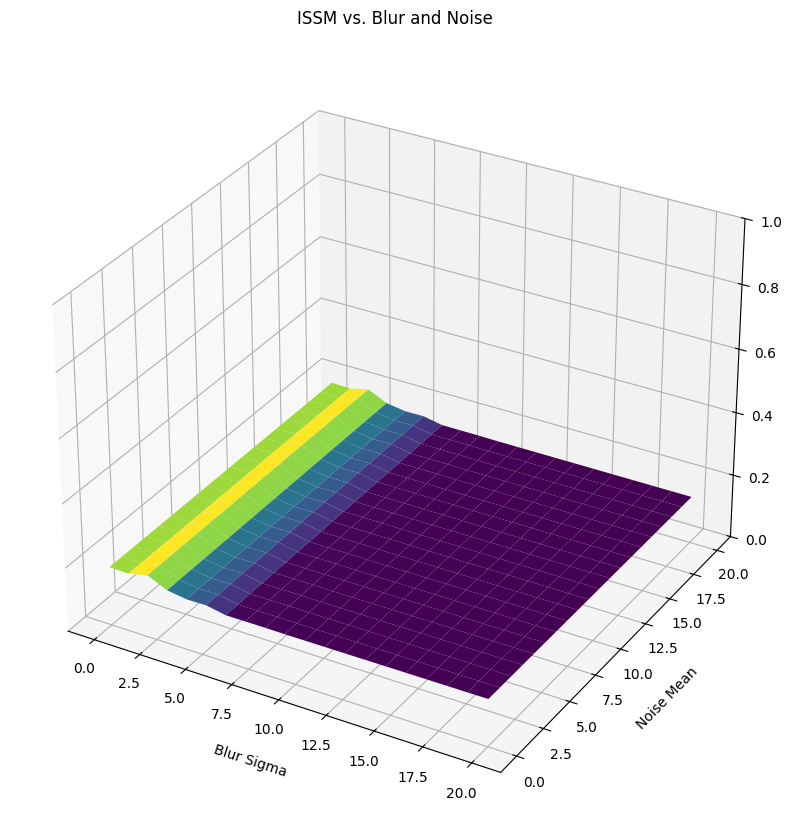

In [7]:
import pickle
import matplotlib.pyplot as plt

with open('pkldata/results_data_mean_5.0.pkl', 'rb') as f:
    (blur_levels, noise_means, fsim_blur, fsim_noise, fsim_combined,
     ssim_blur, ssim_noise, ssim_combined, csim_blur, csim_noise, csim_combined,
     issm_blur, issm_noise, issm_combined) = pickle.load(f)

def plot_results(blur_levels, noise_means, csim_blur, csim_noise, csim_combined, ssim_blur, ssim_noise, ssim_combined, fsim_blur, fsim_noise, fsim_combined, issm_blur, issm_noise, issm_combined):
    """Plot the results of the similarity computations including FSIM, SSIM, CSIM, and ISSM."""
    
    plt.figure(figsize=(14, 7))
    plt.plot(blur_levels, csim_blur, label='Copula-Based Similarity')
    plt.plot(blur_levels, ssim_blur, label='SSIM')
    plt.plot(blur_levels, fsim_blur, label='FSIM')
    plt.plot(blur_levels, issm_blur, label='ISSM')
    plt.xlabel('Blur Sigma')
    plt.ylabel('Similarity Score')
    plt.legend()
    plt.grid()
    plt.show()

    plt.figure(figsize=(14, 7))
    plt.plot(noise_means, csim_noise, label='Copula-Based Similarity')
    plt.plot(noise_means, ssim_noise, label='SSIM')
    plt.plot(noise_means, fsim_noise, label='FSIM')
    plt.plot(noise_means, issm_noise, label='ISSM')
    plt.xlabel('Noise Sigma')
    plt.ylabel('Similarity Score')
    plt.legend()
    plt.grid()
    plt.show()

    from mpl_toolkits.mplot3d import Axes3D
    blur_values, noise_values = np.meshgrid(blur_levels, noise_means, indexing='ij')
    
    fig = plt.figure(figsize=(14, 10))
    ax1 = fig.add_subplot(111, projection='3d')
    ax1.plot_surface(blur_values, noise_values, csim_combined.T, cmap='viridis')
    ax1.set_xlabel('Blur Sigma', labelpad=10)
    ax1.set_ylabel('Noise Mean', labelpad=10)
    ax1.set_zlabel('CSIM', labelpad=10)
    ax1.set_zlim(0.0, 1.0)
    ax1.set_title('CSIM vs. Blur and Noise', pad=20)
    plt.show()

    fig = plt.figure(figsize=(14, 10))
    ax2 = fig.add_subplot(111, projection='3d')
    ax2.plot_surface(blur_values, noise_values, ssim_combined.T, cmap='viridis')
    ax2.set_xlabel('Blur Sigma', labelpad=10)
    ax2.set_ylabel('Noise Mean', labelpad=10)
    ax2.set_zlabel('SSIM', labelpad=10)
    ax2.set_zlim(0.0, 1.0)
    ax2.set_title('SSIM vs. Blur and Noise', pad=20)
    plt.show()

    fig = plt.figure(figsize=(14, 10))
    ax3 = fig.add_subplot(111, projection='3d')
    ax3.plot_surface(blur_values, noise_values, fsim_combined.T, cmap='viridis')
    ax3.set_xlabel('Blur Sigma', labelpad=10)
    ax3.set_ylabel('Noise Mean', labelpad=10)
    ax3.set_zlabel('FSIM', labelpad=10)
    ax3.set_zlim(0.0, 1.0)
    ax3.set_title('FSIM vs. Blur and Noise', pad=20)
    plt.show()

    fig = plt.figure(figsize=(14, 10))
    ax4 = fig.add_subplot(111, projection='3d')
    ax4.plot_surface(blur_values, noise_values, issm_combined.T, cmap='viridis')
    ax4.set_xlabel('Blur Sigma', labelpad=10)
    ax4.set_ylabel('Noise Mean', labelpad=10)
    ax4.set_zlabel('ISSM', labelpad=10)
    ax4.set_zlim(0.0, 1.0)
    ax4.set_title('ISSM vs. Blur and Noise', pad=20)
    plt.show()

plot_results(blur_levels, noise_means, csim_blur, csim_noise, csim_combined,
             ssim_blur, ssim_noise, ssim_combined, fsim_blur, fsim_noise, fsim_combined,
             issm_blur, issm_noise, issm_combined)


In [41]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FFMpegWriter

from similarity_metrics.fsim_quality import FSIMsimilarity
from similarity_metrics.issm_quality import ISSMsimilarity
from CopulaSimilarity.CSM import CopulaBasedSimilarity as CSIMSimilarity
from image_similarity_measures.quality_metrics import ssim

class SimilarityMetrics:
    def __init__(self):
        self.fsim_similarity = FSIMsimilarity()
        self.issm_similarity = ISSMsimilarity()
        self.copula_similarity = CSIMSimilarity()

    def compute_ssim(self, reference_frame, current_frame):
        return ssim(reference_frame, current_frame)

    def compute_fsim(self, reference_frame, current_frame):
        return self.fsim_similarity.fsim(reference_frame, current_frame)

    def compute_issm(self, reference_frame, current_frame):
        return self.issm_similarity.issm(reference_frame, current_frame)

    def compute_csim(self, reference_frame, current_frame):
        csim = self.copula_similarity.compute_local_similarity(reference_frame, current_frame)
        return csim, np.mean(csim)

def process_video(video_path, resolution_factor=8, output_video='output.mp4'):
    metrics = SimilarityMetrics()

    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print("Error: Could not open video file.")
        return

    ret, reference_frame = cap.read()
    if not ret:
        print("Error: Could not read the first frame.")
        cap.release()
        return

    ref_resized = cv2.resize(
        reference_frame, 
        (reference_frame.shape[1] // resolution_factor, 
         reference_frame.shape[0] // resolution_factor)
    )
    ref_rgb = cv2.cvtColor(ref_resized, cv2.COLOR_BGR2RGB)  

    ssim_results = []
    fsim_results = []
    issm_results = []
    csim_results = []
    frame_indices = []

    fig = plt.figure(figsize=(20, 12)) 
    
    gs = fig.add_gridspec(2, 3, height_ratios=[1, 1.5])  

    video_ax = fig.add_subplot(gs[0, 0])
    diff_ax = fig.add_subplot(gs[0, 1])
    csim_ax = fig.add_subplot(gs[0, 2])
    
    plot_ax = fig.add_subplot(gs[1, :])
    
    font_title = 24 
    font_labels = 20  
    font_ticks = 18  

    video_ax.set_title('(a))', fontsize=font_title)
    diff_ax.set_title('(b)', fontsize=font_title)
    csim_ax.set_title('(c)', fontsize=font_title)
    plot_ax.set_title('(d)', fontsize=font_title)
    
    plot_ax.plot([], [], 'g-', label='SSIM')
    plot_ax.plot([], [], 'b-', label='FSIM')
    plot_ax.plot([], [], 'm-', label='ISSM')
    plot_ax.plot([], [], 'r-', label='CSIM')
    plot_ax.set_xlim(0, 100)
    plot_ax.set_ylim(0, 1)
    plot_ax.set_xlabel('Frame Index', fontsize=font_labels)
    plot_ax.set_ylabel('Metric Value', fontsize=font_labels)
    plot_ax.legend(loc='lower left', fontsize=font_labels)
    
    for ax in [video_ax, diff_ax, csim_ax, plot_ax]:
        ax.tick_params(axis='both', which='major', labelsize=font_ticks)

    writer = FFMpegWriter(fps=30, codec='libx264')

    with writer.saving(fig, output_video, dpi=100):
        frame_count = 0
        while True:
            ret, frame = cap.read()
            if not ret:
                break

            current_resized = cv2.resize(
                frame, 
                (ref_resized.shape[1], ref_resized.shape[0]) 
            )
            current_rgb = cv2.cvtColor(current_resized, cv2.COLOR_BGR2RGB)

            ssim_value = metrics.compute_ssim(ref_rgb, current_rgb)
            fsim_value = metrics.compute_fsim(ref_rgb, current_rgb)
            issm_value = metrics.compute_issm(ref_rgb, current_rgb)
            csim_map, csim_mean = metrics.compute_csim(ref_rgb, current_rgb)
            diff_frame = cv2.absdiff(current_rgb, ref_rgb)

            frame_indices.append(frame_count)
            ssim_results.append(ssim_value)
            fsim_results.append(fsim_value)
            issm_results.append(issm_value)
            csim_results.append(csim_mean)

            video_ax.imshow(current_rgb)
            video_ax.axis('off')

            diff_rgb = cv2.cvtColor(diff_frame, cv2.COLOR_BGR2RGB)
            diff_ax.imshow(diff_rgb)
            diff_ax.axis('off')

            csim_map_resized = cv2.resize(csim_map, (current_resized.shape[1], current_resized.shape[0]))  
            csim_ax.imshow(csim_map_resized, cmap='hot', interpolation='nearest')
            csim_ax.axis('off')

            plot_ax.clear()
            plot_ax.plot(frame_indices, ssim_results, 'g-', label='SSIM')
            plot_ax.plot(frame_indices, fsim_results, 'b-', label='FSIM')
            plot_ax.plot(frame_indices, issm_results, 'm-', label='ISSM')
            plot_ax.plot(frame_indices, csim_results, 'r-', label='CSIM')
            plot_ax.set_xlim(0, len(frame_indices))
            plot_ax.set_ylim(0, 1)
            plot_ax.set_xlabel('Frame Index', fontsize=font_labels)
            plot_ax.set_ylabel('Metric Value', fontsize=font_labels)
            plot_ax.set_title('(d)', fontsize=font_title)
            plot_ax.legend(loc='lower left', fontsize=font_labels)

            plt.draw()
            writer.grab_frame()

            frame_count += 1

    fig.savefig('final_frame.pdf', bbox_inches='tight')

    cap.release()
    plt.close(fig)


In [42]:
video_path = 'MRI_brain.mp4'

process_video(video_path, resolution_factor=2, output_video='analysis4.mp4')


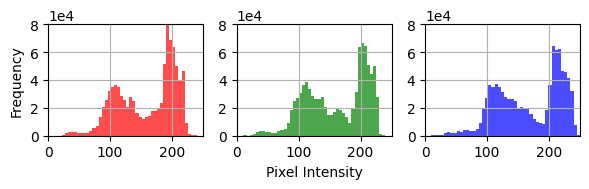

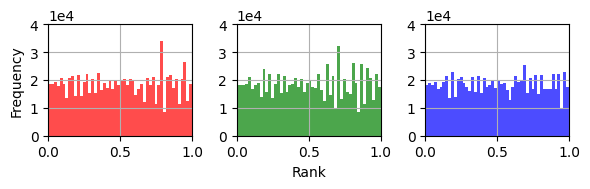

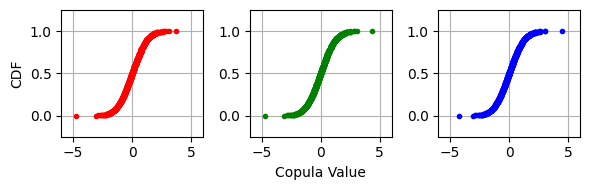

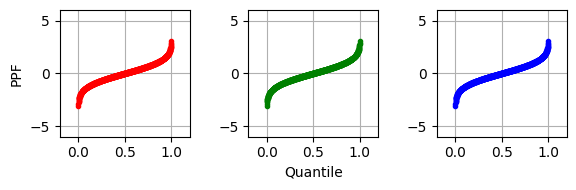

In [11]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import scipy.stats as stats

def plot_features_and_distributions(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
    channels = ['Red', 'Green', 'Blue']

    # Plot for pixel intensity distributions
    plt.figure(figsize=(6, 2))  # Adjusted for wider figure
    for i in range(3):
        channel_data = image[:, :, i].flatten()
        
        plt.subplot(1, 3, i + 1)
        plt.hist(channel_data, bins=50, color=channels[i].lower(), alpha=0.7)
        plt.xlim(0, 250)
        plt.ylim(0, 8e4)
        plt.grid(True)
        plt.ticklabel_format(style='sci', axis='y', scilimits=(4, 4))
        if i != 0:
            plt.ylabel('')  
        else:
            plt.ylabel('Frequency')
        if i != 1:
            plt.xlabel('') 
        else:
            plt.xlabel('Pixel Intensity')

    plt.tight_layout()
    plt.savefig('pixel_intensity_distributions.pdf', format='pdf')  
    plt.show()

    # Plot for ranks
    plt.figure(figsize=(6, 2))  # Adjusted for wider figure
    for i in range(3):
        channel_data = image[:, :, i].flatten()
        ranks = stats.rankdata(channel_data) / (len(channel_data) + 1)
        
        plt.subplot(1, 3, i + 1)
        plt.hist(ranks, bins=50, color=channels[i].lower(), alpha=0.7)
        plt.xlim(0, 1)
        plt.ylim(0, 4e4)
        plt.grid(True)
        plt.ticklabel_format(style='sci', axis='y', scilimits=(4, 4)) 
        if i != 0:
            plt.ylabel('')  
        else:
            plt.ylabel('Frequency')
        if i != 1:
            plt.xlabel('')  
        else:
            plt.xlabel('Rank')

    plt.tight_layout()
    plt.savefig('ranks_distribution.pdf', format='pdf')  
    plt.show()

    # Plot for CDF
    plt.figure(figsize=(6, 2))  # Adjusted for wider figure
    for i in range(3):
        channel_data = image[:, :, i].flatten()
        ranks = stats.rankdata(channel_data) / (len(channel_data) + 1)
        
        copula = stats.norm.ppf(ranks)
        copula = np.nan_to_num(copula, nan=0.0, posinf=0.0, neginf=0.0)
        
        reduced_indices = np.linspace(0, len(copula) - 1, 1000).astype(int)
        sorted_copula = np.sort(copula)[reduced_indices]
        cdf = np.linspace(0, 1, len(reduced_indices))
        
        plt.subplot(1, 3, i + 1)
        plt.plot(sorted_copula, cdf, marker='.', linestyle='none', color=channels[i].lower())
        plt.xlim(-6, 6)
        plt.ylim(-0.25, 1.25)
        plt.grid(True)
        if i != 0:
            plt.ylabel('')
        else:
            plt.ylabel('CDF')
        if i != 1:
            plt.xlabel('')
        else:
            plt.xlabel('Copula Value')

    plt.tight_layout()
    plt.savefig('cdf_distribution.pdf', format='pdf')  
    plt.show()

    # Plot for PPF
    plt.figure(figsize=(6, 2))  # Adjusted for wider figure
    for i in range(3):
        ppf_quantiles = np.linspace(0, 1, 1000)
        ppf = stats.norm.ppf(ppf_quantiles)

        plt.subplot(1, 3, i + 1)
        plt.plot(ppf_quantiles, ppf, marker='.', linestyle='none', color=channels[i].lower())
        plt.xlim(-0.2, 1.2)
        plt.ylim(-6, 6)
        plt.grid(True)
        if i != 0:
            plt.ylabel('')  
        else:
            plt.ylabel('PPF')
        if i != 1:
            plt.xlabel('')  
        else:
            plt.xlabel('Quantile')

    plt.tight_layout()
    plt.savefig('ppf_distribution.pdf', format='pdf') 
    plt.show()

# Path to your image
image_path = 'examples/image_test.jpg'
plot_features_and_distributions(image_path)
